# Временные ряды

> Временной ряд – это последовательность значений, описывающих протекающий во времени процесс, измеренных в последовательные моменты времени, обычно через равные промежутки

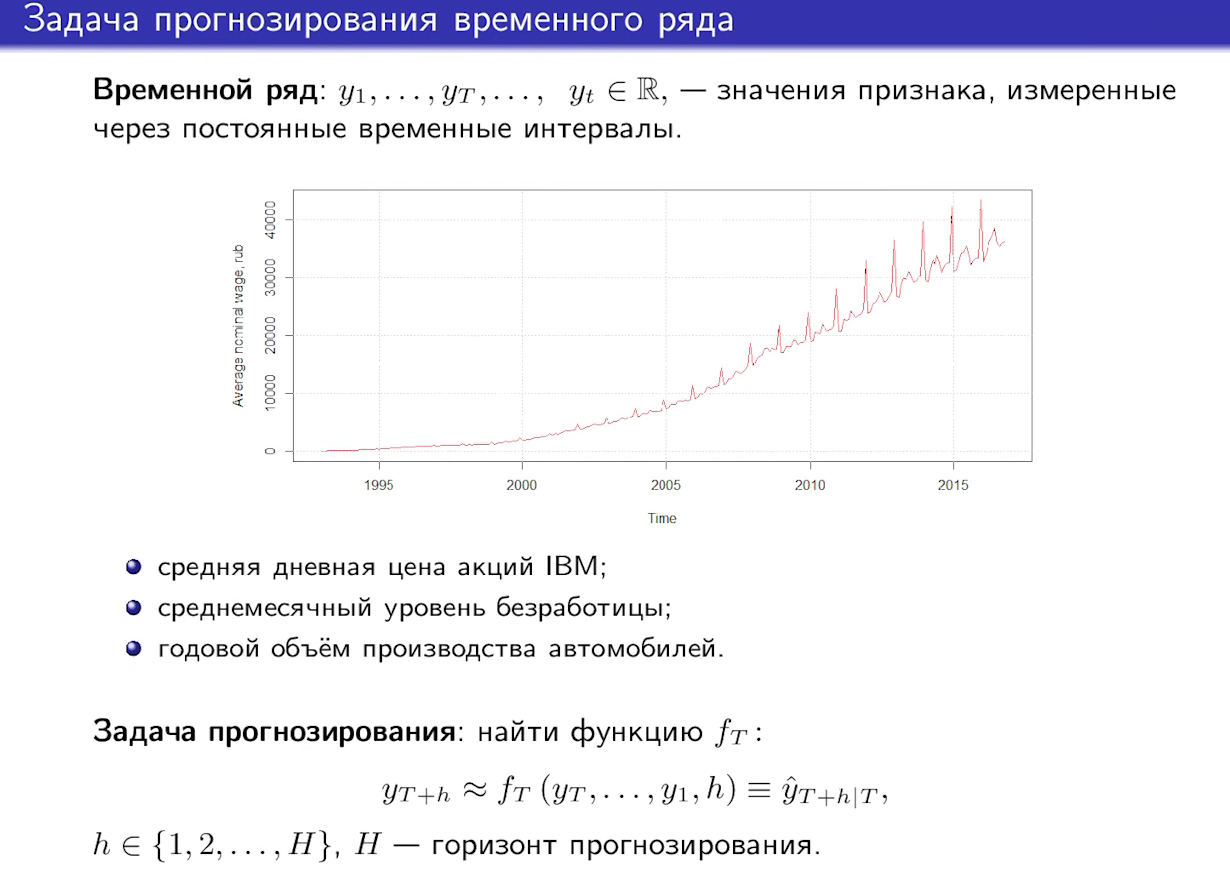

In [110]:
Image('images/tsintro.png', width=500)

In [2]:
from setup_libs import *

In [50]:
data = pd.read_csv('data_/tsla.us.txt').drop(columns=['OpenInt'])
data['Date'] = pd.to_datetime(data['Date'])
data = data.set_index('Date')
data.head()

,Open,High,Low,Close,Volume
Date,,,,,
2010-06-28,17.00,17.00,17.00,17.00,0
2010-06-29,19.00,25.00,17.54,23.89,18783276
2010-06-30,25.79,30.42,23.30,23.83,17194394
2010-07-01,25.00,25.92,20.27,21.96,8229863
2010-07-02,23.00,23.10,18.71,19.20,5141807


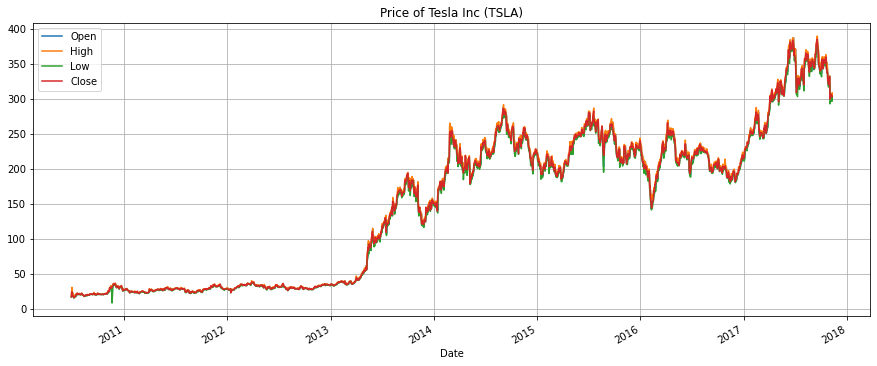

In [51]:
data[['Open', 'High', 'Low', 'Close']].plot(figsize=(15, 6), 
                                            title='Price of Tesla Inc (TSLA)')
plt.grid()

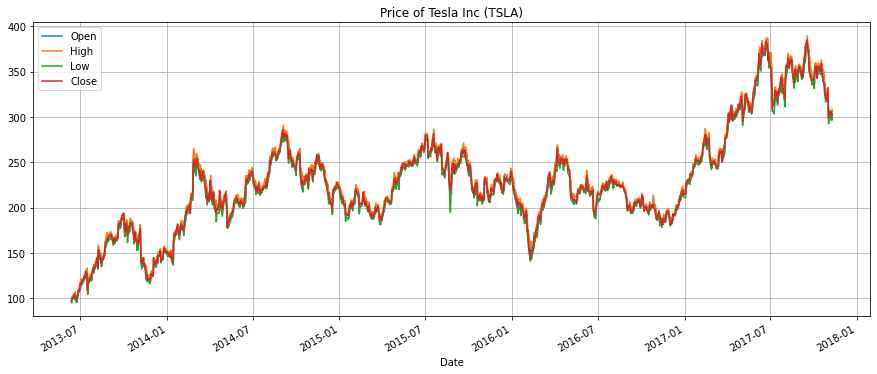

In [52]:
data = data.iloc[int(len(data)*0.4):]
data[['Open', 'High', 'Low', 'Close']].plot(figsize=(15, 6), 
                                            title='Price of Tesla Inc (TSLA)')
plt.grid()

## Daily return
Сколько заработаем, если вчера вечером купили, а сегодня вечером продадим.

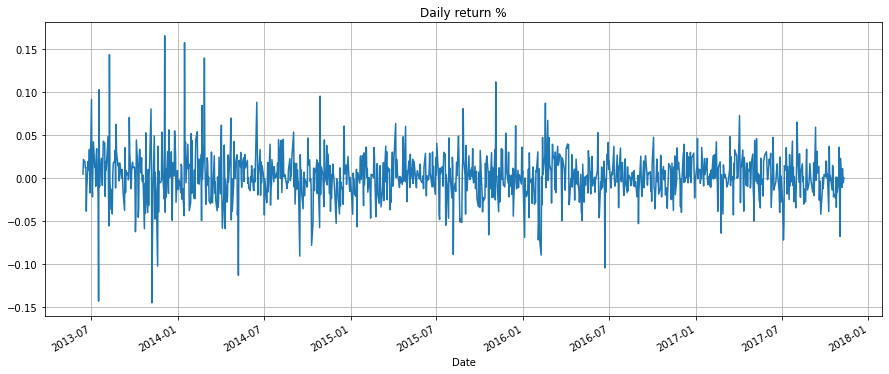

In [15]:
data['Daily return'] = data['Close'].pct_change()
data['Daily return'].plot(figsize=((15,6)), title='Daily return %')
plt.grid()

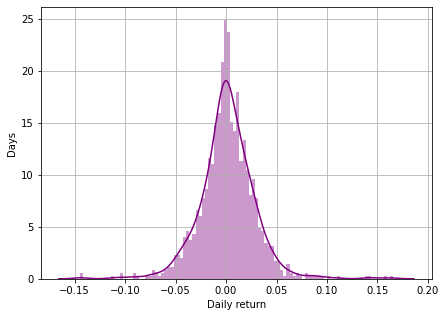

In [16]:
plt.figure(figsize=(7,5))
sns.distplot(data['Daily return'].dropna(), bins=100, color='purple')
plt.ylabel('Days')
plt.grid()

## Постановка задачи

Пусть данные $(X, y)$, где $X$ - это дата, а $y$ - некоторое значение параметра. 

Необходимо делать предсказание $y$ на будущее.

Основные отличия:

* Объекты **ЗАВИСИМЫ** в отличие от регресии/классификации/кластеризации.

* Возможно есть какие-то доп. пирзнаки для каждой даты, но обычно только дата.

Пока будем предсказывать $y_{t+1}$, потом посмотрим, что будем с горизонтом.

Метрика $MSE$

In [53]:
data['Close+1'] = data['Close'].shift(-1)
data['Close+5'] = data['Close'].shift(-5)
data['Close+10'] = data['Close'].shift(-10)

data = data[:-10]

In [54]:
data[['Close', 'Close+1', 'Close+5', 'Close+10']].tail(12)

,Close,Close+1,Close+5,Close+10
Date,,,,
2017-10-12,355.68,355.57,351.81,326.17
2017-10-13,355.57,350.60,345.10,320.87
2017-10-16,350.60,355.75,337.02,320.08
2017-10-17,355.75,359.65,337.34,331.53
2017-10-18,359.65,351.81,325.84,321.08
2017-10-19,351.81,345.10,326.17,299.26
2017-10-20,345.10,337.02,320.87,306.09
2017-10-23,337.02,337.34,320.08,302.78
2017-10-24,337.34,325.84,331.53,306.05


In [69]:
from sklearn.metrics import mean_squared_error as MSE

def result(data, sol_cols, targets=['Close+1', 'Close+10'], test_size=0.1):
    
    test_size = 0.1
    test_data = data[-int(len(data)*test_size):]
    for target in targets:
        title_ = target + ': '
        for sol in sol_cols:
            error = MSE(test_data[sol], test_data[target])
            title_ += '{0} MSE: {1:.2f}, '.format(sol, error)
        test_data[[target, *sol_cols]].plot(figsize=(15, 6), 
                                            title=title_)
        plt.grid()

## Решения

### 1. Очень тупое

$$y_{t+h} = y_{t}$$

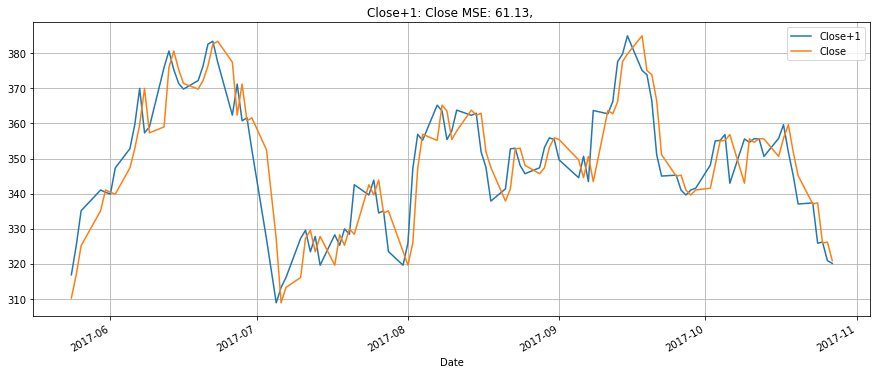

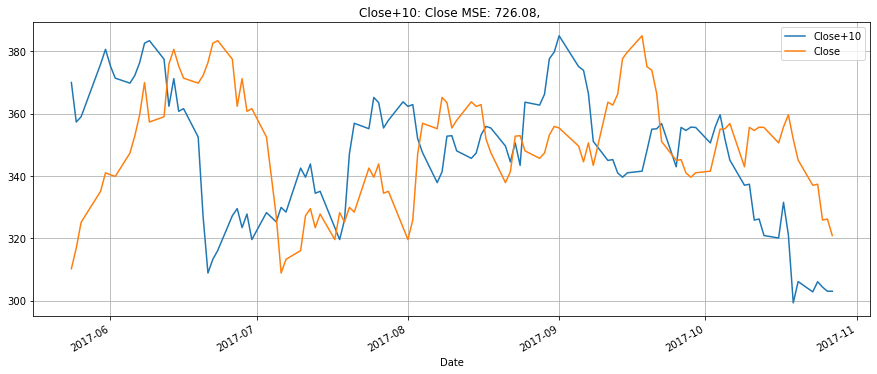

In [70]:
result(data, sol_cols = ['Close'])

### 2. Moving average (MA)

Скользящее среднее с окном длины $n$

$$\hat{y}_{t+1} = \frac{1}{n}\sum_{i=1}^{n}y_{t-i}$$

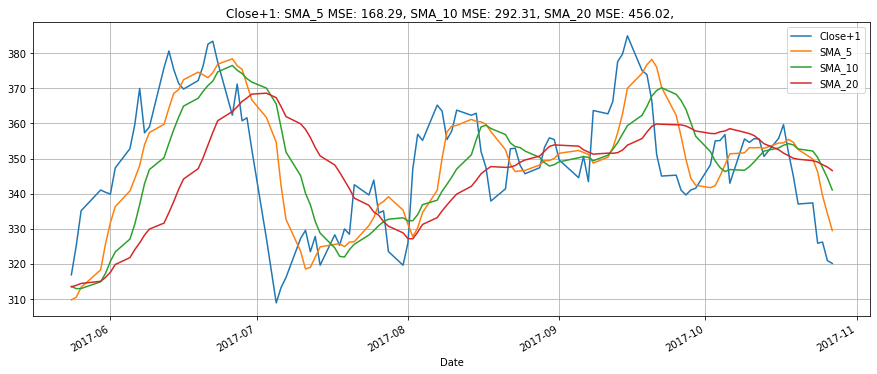

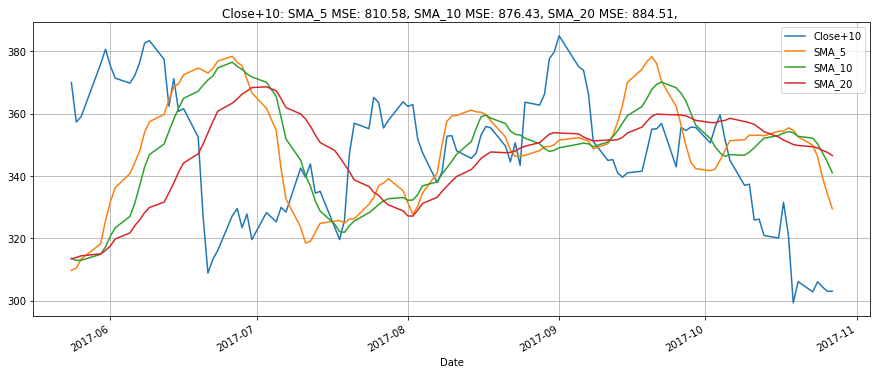

In [71]:
data['SMA_5']  = data['Close'].rolling(5).mean()
data['SMA_10'] = data['Close'].rolling(10).mean()
data['SMA_20'] = data['Close'].rolling(20).mean()

result(data, sol_cols = ['SMA_5','SMA_10', 'SMA_20'])

### 3. Exponential average

$$\hat{y}_{t+1} = \alpha \cdot y_t + (1-\alpha) \cdot \hat y_{t} $$

Здесь модельное значение представляет собой средневзвешенную между текущим истинным и предыдущим модельным значениями. Вес $\alpha$ называется сглаживающим фактором. Он определяет, как быстро мы будем "забывать" последнее доступное истинное наблюдение. Чем меньше $\alpha$, тем больше влияния оказывают предыдущие модельные значения, и тем сильнее сглаживается ряд. 

Экспоненциальность скрывается в рекурсивности функции - каждый раз мы умножаем $(1-\alpha)$ на предыдущее модельное значение, которое, в свою очередь, также содержало в себе $(1-\alpha)$, и так до самого начала.

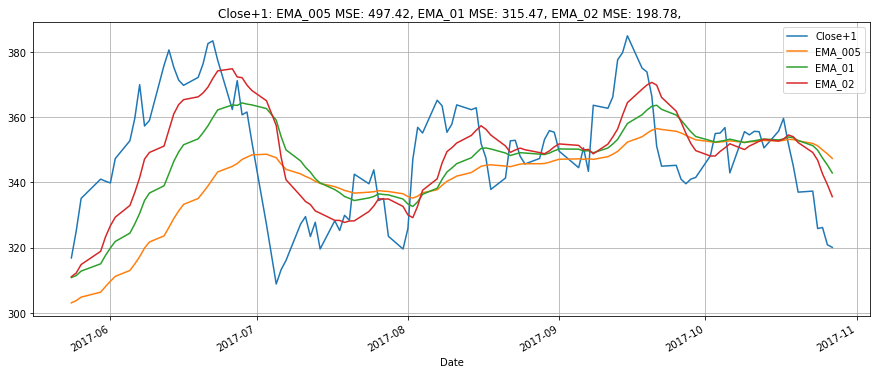

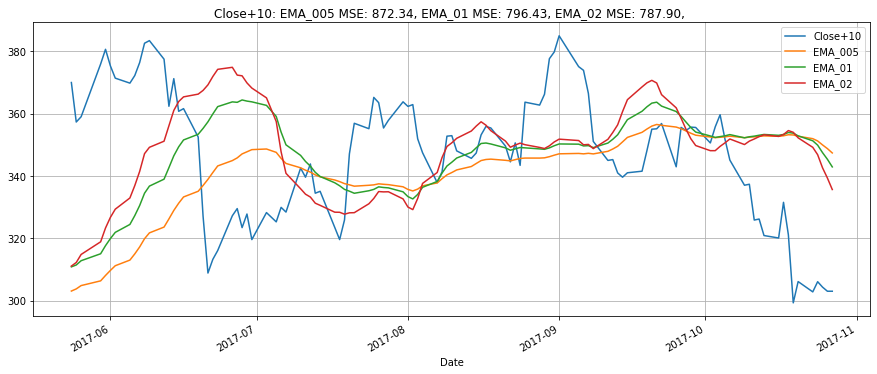

In [72]:
data['EMA_005'] = data['Close'].ewm(alpha=0.05).mean()
data['EMA_01']  = data['Close'].ewm(alpha=0.1).mean()
data['EMA_02']  = data['Close'].ewm(alpha=0.2).mean()


result(data, sol_cols = ['EMA_005', 'EMA_01', 'EMA_02'])

In [ ]:
from catboost import CatBoostRegressor
from sklearn.model_selection import train_test_split

X = data[['Close','SMA_5','SMA_10', 'SMA_20', 'EMA_005', 'EMA_01', 'EMA_02']]
y1 = data['Close+1']
y2 = data['Close+10']


In [82]:

X_train, X_test, y_train, y_test = train_test_split(X, y1,test_size=0.1, shuffle=False)
                   
model1 = CatBoostRegressor(silent=True).fit(X_train, y_train)
                                                    
MSE(model1.predict(X_test), y_test)                                            

1359.875546068114

In [85]:

X_train, X_test, y_train, y_test = train_test_split(X, y2, test_size=0.1, shuffle=False)
                   
model2 = CatBoostRegressor(silent=True).fit(X_train, y_train)
                                                    
MSE(model2.predict(X_test), y_test)                                            

433.3851375726413